<a href="https://www.kaggle.com/code/officialaa/final-ipynb?scriptVersionId=199755615" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import pandas as pd

url="https://raw.githubusercontent.com/sap03rocks/mimic_lstm/refs/heads/main/noise_ppg%20(2).csv"
# Read the data into a DataFrame
data = pd.read_csv(url, header=None)
data = data.drop(columns=[0,1])
data

,2
0,noise_ppg
1,-0.4810228991995381
2,-0.5289308826944845
3,-0.4948818163572952
4,-0.5177419553315811
...,...
4997,-0.23531966350053654
4998,-0.27220099788555685
4999,-0.20599570471430165
5000,-0.21895456437800329


In [16]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Assuming 'data' is already defined and loaded
# Ensure 'data' is a pandas Series
if isinstance(data, pd.DataFrame):
    data = data.iloc[:, 0]  # Select the first column or the relevant column

# Handle non-numeric values
data = pd.to_numeric(data, errors='coerce')
data = data.dropna()

# Reshape and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 8
X, y = create_sequences(scaled_data, seq_length)

# Reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define model
model = Sequential()
model.add(Input(shape=(seq_length, n_features)))
model.add(Bidirectional(LSTM(200, return_sequences=True, activation='relu')))
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
model.add(Bidirectional(LSTM(100, return_sequences=False, activation='relu')))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Summarize model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 8, 400)         │       323,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 8, 200)         │       400,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 965,001 (3.68 MB)

 Trainable params: 965,001 (3.68 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history=model.fit(X, y, epochs=40, batch_size=1, validation_split=0.2)
results = model.evaluate(X_test, y_test, batch_size=1)
print("Test loss:", results)

Epoch 1/40
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 0.0076 - val_loss: 0.0011
Epoch 2/40
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 3/40
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 4/40
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0014 - val_loss: 8.9310e-04
Epoch 5/40
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 6/40
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/40
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0012 - val_loss: 8.2477e-04
Epoch 8/40
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/40
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/40
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 11/40
3994/3994 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0011 - val_loss: 8.3531e-04
Epoch 1

In [18]:
# Assuming you have already trained your LSTM model
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X, y, batch_size=1)
print("Test loss, test accuracy:", results)

# Generate predictions (probabilities) on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X[:3])
print("Predictions shape:", predictions.shape)

Evaluate on test data
4993/4993 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0015
Test loss, test accuracy: 0.0014693301636725664
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions shape: (3, 1)


W0000 00:00:1728226637.424981     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1728226637.425600     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [19]:


# Assuming you have already trained your LSTM model
# Generate predictions for the entire dataset
predictions = model.predict(X)
print(predictions)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Prediction'])

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
[[0.23520873]
 [0.23878728]
 [0.25838482]
 ...
 [0.38040847]
 [0.39440975]
 [0.40805495]]
Predictions saved to predictions.csv


In [20]:
# Predict on the training data
train_predict = model.predict(X_train)

# Predict on the testing data
test_predict = model.predict(X_test)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


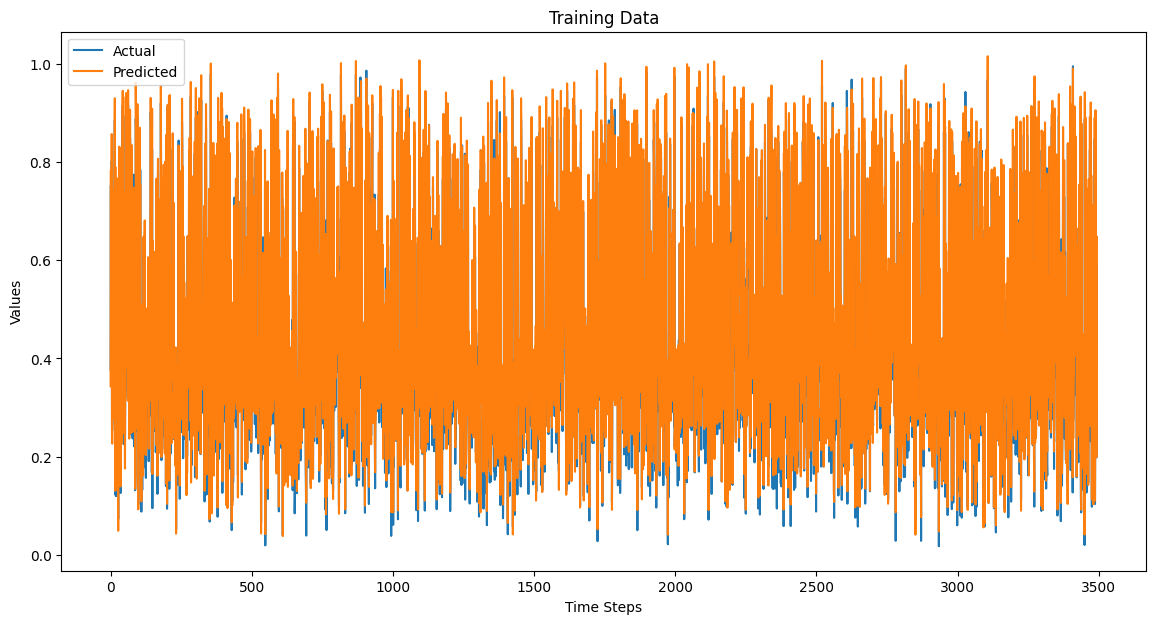

In [21]:
import matplotlib.pyplot as plt

# Predict on the training data
train_predict = model.predict(X_train)

# Predict on the testing data
test_predict = model.predict(X_test)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot training data

plt.plot(y_train, label='Actual')

plt.title('Training Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')


plt.plot(train_predict, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Values')

plt.legend()
plt.show()


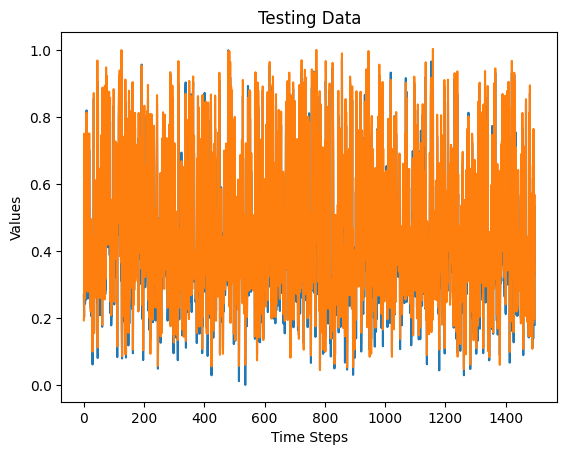

In [22]:
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Testing Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()

In [23]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test.flatten(),  # Flatten in case y_test is not 1D
    'Predicted': test_predict.flatten()  # Flatten in case test_predict is not 1D
})

# Save the DataFrame to a CSV file
results_df.to_csv('test_vs_actual.csv', index=True)

print("Test vs Actual results saved to test_vs_actual.csv")


Test vs Actual results saved to test_vs_actual.csv


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.0040345687386413535
MAE: 0.05183765893922573
R^2: 0.9704918941015147


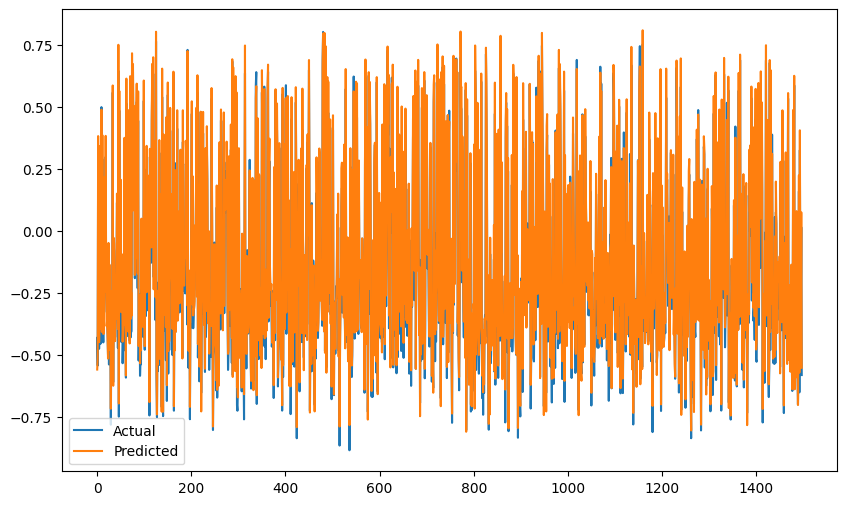

<Figure size 640x480 with 0 Axes>

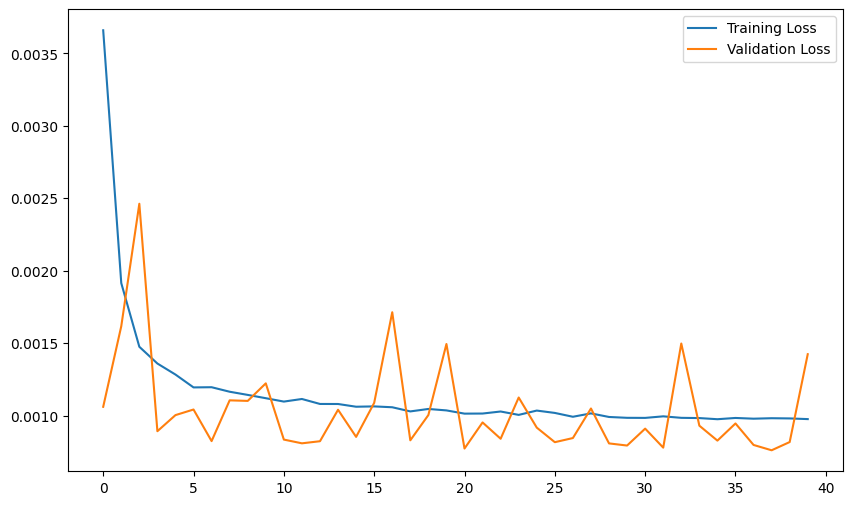

<Figure size 640x480 with 0 Axes>

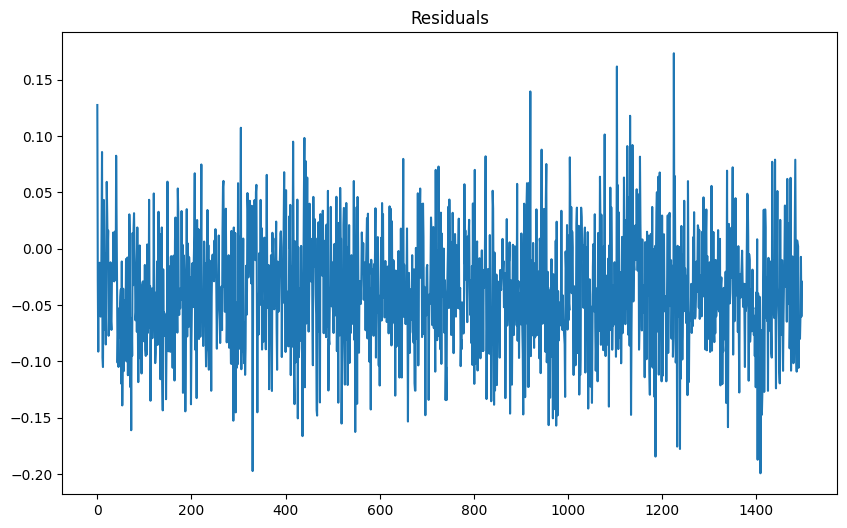

<Figure size 640x480 with 0 Axes>

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# make predictions
y_pred = model.predict(X_test)

# inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

# plot predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.show()
plt.savefig('predictions_vs_actual.png')

# plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('training_validation.png')
# plot residuals
residuals = y_test_inv - y_pred_inv
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()
plt.savefig('residual.png')
